In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import os
import sys
# Determine the absolute path to your training data folder.
project_root = os.path.abspath(
    os.path.join(os.path.dirname(__file__) if '__file__' in globals() else os.getcwd(), '..')
)

# Insert project_root to sys.path if needed.
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Build the path to the data folder (assuming your data folder is directly under the project root)
data_dir = os.path.join(project_root, 'data')
data_small_dir = os.path.join(project_root, 'data_small')

print("Project root:", project_root)
print("Data directory:", data_dir)

from models import get_model, effnetv2b0_base, effnetv2b3_base,train_model

from keras.models import Model
from keras.preprocessing import image_dataset_from_directory
import tensorflow as tf

Project root: /home/phigep/fh/face-mask-detection
Data directory: /home/phigep/fh/face-mask-detection/data


In [12]:
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
test_small_dir = os.path.join(data_small_dir, 'test')

In [13]:
BATCH_SIZE = 32
ORIGINAL_IMAGE_SIZE = (None, None)  # Allow variable sizes
TARGET_IMAGE_SIZE = (224, 224)       # EfficientNetV2's expected input size
EPOCHS = 25
AUTOTUNE = tf.data.AUTOTUNE

In [14]:
from preprocessing import get_augmented_dataset
train_dataset = get_augmented_dataset(train_dir)
test_dataset = get_augmented_dataset(test_dir,batch_size=1,shuffle=False)
test_small_dataset = get_augmented_dataset(test_small_dir,batch_size=1,shuffle=False)


Found 109638 files belonging to 2 classes.
Found 19351 files belonging to 2 classes.
Found 1132 files belonging to 2 classes.


In [15]:
enetb0_model = get_model(effnetv2b0_base,input_dim=(224,224,3), resize_dim=(224,224,3), classes=2,classifier_activation="sigmoid", training_base=False)

In [16]:
from keras.optimizers import AdamW
optimizer = AdamW(learning_rate=5e-5)

In [17]:
enetb0_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)


change back to python to train:

In [18]:

enetb0_model,history = train_model(checkpoint_dir="./checkpoints/",
                                   epochs=3,
                                   model=enetb0_model,
                                   train_data=train_dataset,
                                   val_data=test_dataset,
                                   )

Epoch 1/3


I0000 00:00:1737883733.647074    7075 service.cc:148] XLA service 0x7cc528003a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737883733.647715    7075 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-01-26 10:28:54.798190: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737883737.339245    7075 cuda_dnn.cc:529] Loaded cuDNN version 90600


   4/3427 ━━━━━━━━━━━━━━━━━━━━ 2:41 47ms/step - accuracy: 0.6016 - loss: 0.6760  

I0000 00:00:1737883755.674737    7075 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3427/3427 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9837 - loss: 0.0579
Epoch 1: val_loss improved from inf to 0.00096, saving model to ./checkpoints/functional_2.keras
3427/3427 ━━━━━━━━━━━━━━━━━━━━ 340s 86ms/step - accuracy: 0.9837 - loss: 0.0579 - val_accuracy: 0.9998 - val_loss: 9.5812e-04 - learning_rate: 5.0000e-05
Epoch 2/3
3426/3427 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9996 - loss: 0.0015
Epoch 2: val_loss improved from 0.00096 to 0.00080, saving model to ./checkpoints/functional_2.keras
3427/3427 ━━━━━━━━━━━━━━━━━━━━ 271s 79ms/step - accuracy: 0.9996 - loss: 0.0015 - val_accuracy: 0.9998 - val_loss: 7.9573e-04 - learning_rate: 5.0000e-05
Epoch 3/3
3426/3427 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9997 - loss: 0.0012
Epoch 3: val_loss did not improve from 0.00080
3427/3427 ━━━━━━━━━━━━━━━━━━━━ 268s 78ms/step - accuracy: 0.9997 - loss: 0.0012 - val_accuracy: 0.9997 - val_loss: 0.0016 - learning_rate: 5.0000e-05


In [20]:
from keras.models import load_model
enetb0_model = load_model("./checkpoints/functional_1.keras")

2025-01-26 10:44:47.232400: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


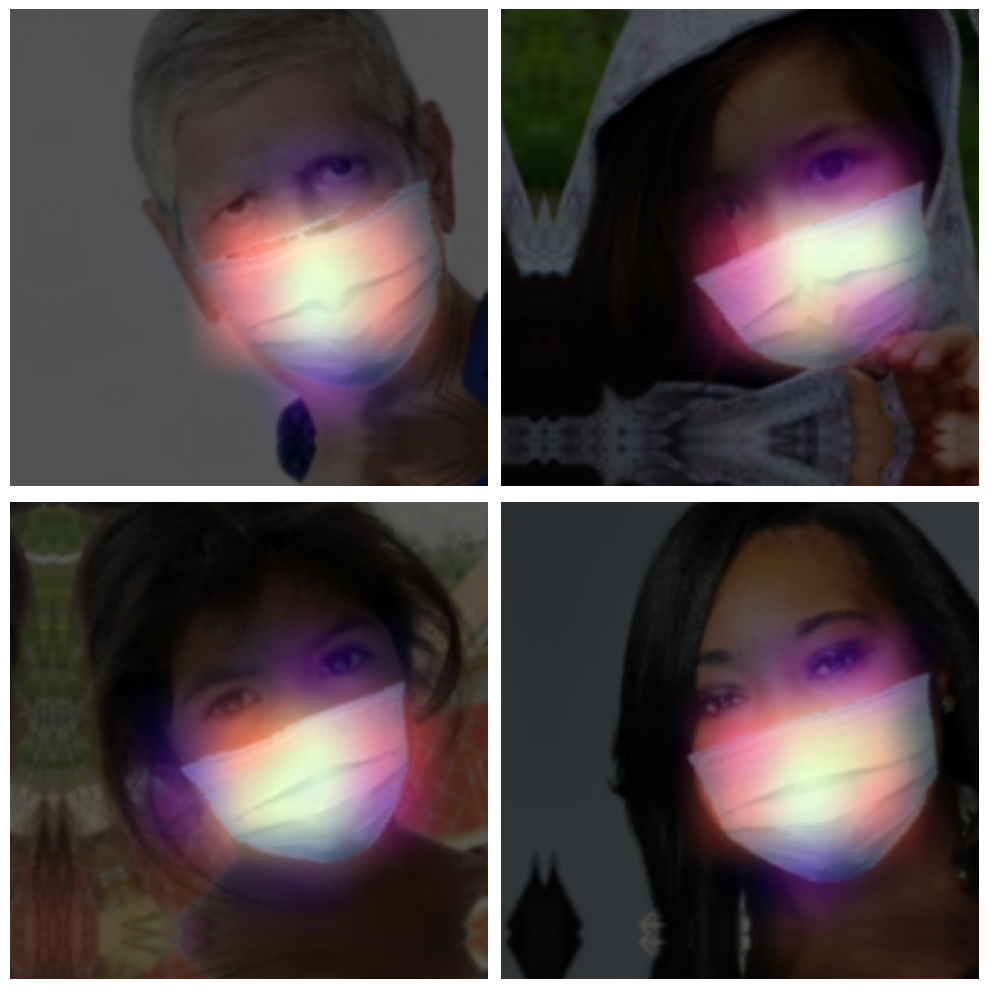

In [21]:
from eval import make_gradcam_heatmap, superimpose_gradcam,plot_images_grid
import matplotlib.pyplot as plt
final_images=[]
for images, labels in test_dataset.take(4):
    heatmap = make_gradcam_heatmap(model=enetb0_model,
                         last_conv_layer_name="efficientnetv2-b0",
                         img_array=images,
                         )
    final = superimpose_gradcam(heatmap=heatmap, img=images[0],alpha=2)
    final_images.append(final)
p=plot_images_grid(final_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


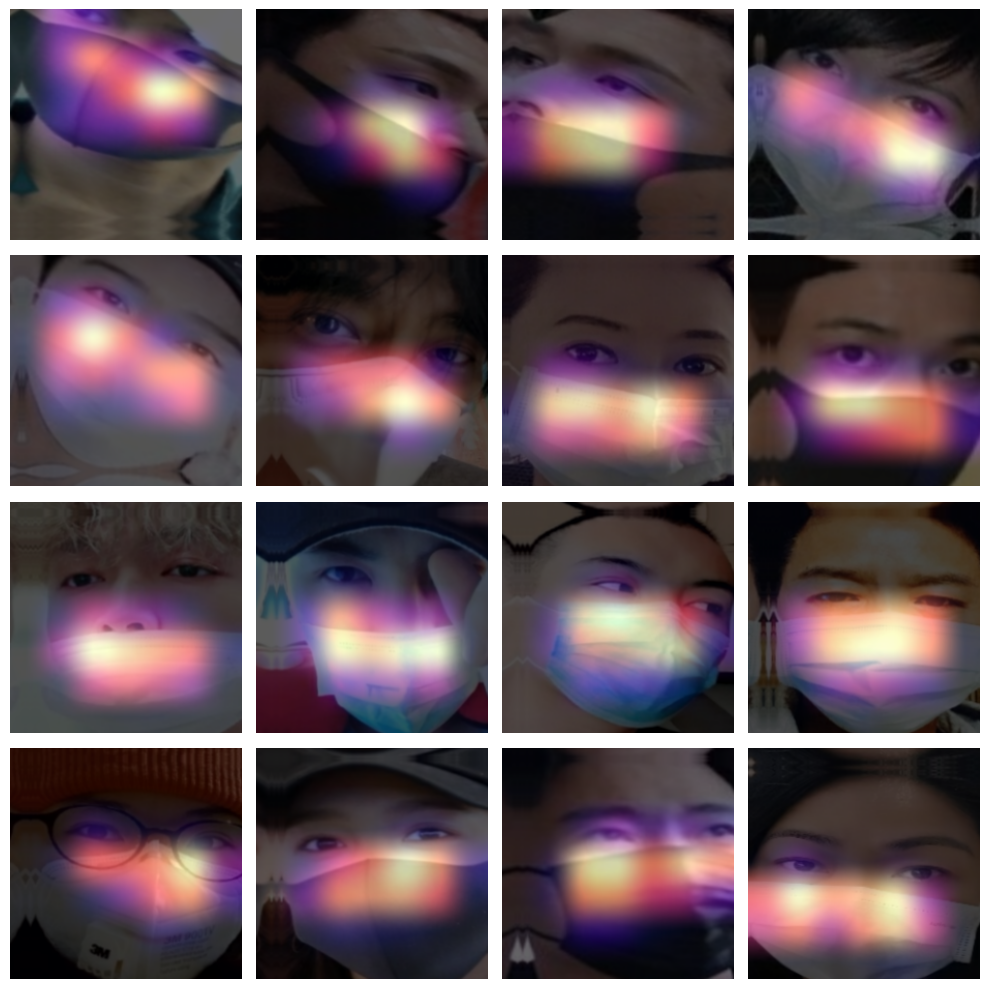

In [33]:
import numpy as np
final_images=[]
preds = []
labels = []
for images, label in test_small_dataset.take(16):
    heatmap = make_gradcam_heatmap(model=enetb0_model,
                         last_conv_layer_name="efficientnetv2-b0",
                         img_array=images,
                         )
    pred= enetb0_model.predict(images)
    preds.append(int(np.argmax(pred)))
    labels.append(int(np.argmax(label)))
    final = superimpose_gradcam(heatmap=heatmap, img=images[0],alpha=2)
    final_images.append(final)
p=plot_images_grid(final_images)
print(labels)
print(preds)

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, confusion_matrix, classification_report

def evaluate_model(test_dataset, y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    classes = np.unique(y_true)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    misclassified = []
    for (image, label) in test_dataset:
        idx = len(misclassified)
        pred = y_pred[idx]
        if np.argmax(label.numpy(),axis=1) != pred:
            misclassified.append(image.numpy())
    return {'accuracy': acc, 'f1_score': f1, 'matthews_corrcoef': mcc, 'classification_report': report}, misclassified


In [35]:
def get_y_true(test_dataset):
    y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
    return y_true
y_true = get_y_true(test_dataset)
y_true = np.argmax(y_true, axis=1)

In [36]:
from sklearn.metrics import accuracy_score,f1_score,matthews_corrcoef, confusion_matrix
y_preds= enetb0_model.predict(test_dataset)
y_preds = np.argmax(y_preds, axis=1)

19351/19351 ━━━━━━━━━━━━━━━━━━━━ 98s 5ms/step


In [26]:
y_preds

array([0, 0, 0, ..., 1, 1, 1])

In [27]:
y_true

array([0, 0, 0, ..., 1, 1, 1])

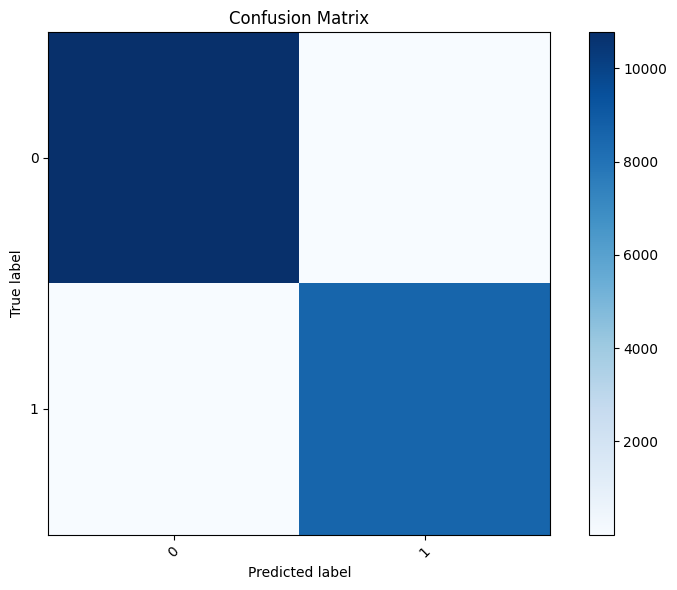

2025-01-26 10:47:03.963685: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


({'accuracy': 0.999844969252235,
  'f1_score': 0.9998449701758451,
  'matthews_corrcoef': np.float64(0.9996858764072106),
  'classification_report': {'0': {'precision': 0.9999072011878248,
    'recall': 0.9998144195972906,
    'f1-score': 0.9998608082401522,
    'support': 10777.0},
   '1': {'precision': 0.9997667638483965,
    'recall': 0.9998833683228365,
    'f1-score': 0.9998250626858709,
    'support': 8574.0},
   'accuracy': 0.999844969252235,
   'macro avg': {'precision': 0.9998369825181106,
    'recall': 0.9998488939600636,
    'f1-score': 0.9998429354630116,
    'support': 19351.0},
   'weighted avg': {'precision': 0.9998449765096036,
    'recall': 0.999844969252235,
    'f1-score': 0.9998449701758451,
    'support': 19351.0}}},
 [array([[[[165.16254 ,  97.860535,  49.55348 ],
           [170.16957 , 100.945694,  54.757717],
           [170.00273 , 100.710495,  54.596416],
           ...,
           [153.97192 ,  81.08093 ,  51.12497 ],
           [151.22029 ,  79.01251 ,  47.

In [28]:
evaluate_model(test_dataset,y_true,y_preds)